# Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator <br>-- Jacobian Ops --

## This operator is contributed by Chevron Energy Technology Company (2020)

This operator is based on simplfications of the systems presented in:
<br>**Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1

## Introduction 

The goal of this tutorial set is to generate and prove correctness of modeling and inversion capability in Devito for variable density visco- acoustics using an energy conserving form of the wave equation. We describe how the linearization of the energy conserving *skew self adjoint* system with respect to modeling parameters allows using the same modeling system for all nonlinear and linearized forward and adjoint finite difference evolutions. 

This notebook implements the linearized (Jacobian) ```forward``` and ```adjoint``` modeling operations and is the second in a set of 3, beginning with a notebook that implements the nonlinear ops ([ssa_01_iso_implementation1.ipynb](ssa_01_iso_implementation1.ipynb)), and finishing with a notebook that tests the correctness of the implemented operators ([ssa_03_iso_correctness.ipynb](ssa_03_iso_correctness.ipynb)). Note there are similar notebooks implementing and testing operators for VTI and TTI anisotropy.

Please review the previous tutorial [ssa_01_iso_implementation1.ipynb](ssa_01_iso_implementation1.ipynb) before this one. 

## Outline 
1. Define symbols [[link]](#ln_symbols) 
2. The linearization [[link]](#ln_linearization) 
3. Create the Devito grid and model fields [[link]](#ln_grid_and_model) 
4. Implement the linearized forward operator [[link]](#ln_linearized_forward) 
5. Exercise the linearized forward operator [[link]](#ln_linearized_forward_run) 
6. Implement the linearized adjoint operator [[link]](#ln_linearized_adjoint) 
7. Exercise the linearized adjoint operator [[link]](#ln_linearized_adjoint_run) 

<a id="ln_symbols"></a>
## Table of symbols

| Symbol &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Description  | Dimensionality | 
|:---|:---|:---|
| $\omega_c = 2 \pi f$ | center angular frequency | constant |
| $v(x,y,z)$   | Total P wave velocity ($v_0+\delta v$) | function of space |
| $v_0(x,y,z)$   | Reference P wave velocity    | function of space |
| $\delta v(x,y,z)$   | Perturbation to P wave velocity    | function of space |
| $b(x,y,z)$   | buoyancy $(1 / \rho)$ | function of space |
| $Q(x,y,z)$   | Attenuation at frequency $\omega_c$ | function of space |
| $P(t,x,y,z)$ | Total pressure wavefield ($P_0+\delta P$)| function of time and space |
| $P_0(t,x,y,z)$ | Reference pressure wavefield | function of time and space |
| $\delta P(t,x,y,z)$ | Perturbation to pressure wavefield | function of time and space |
| $s(t,x,y,z)$ | Source term        | function of time, localized in space |
| $\overrightarrow{\partial_x},\overrightarrow{\partial_y},\overrightarrow{\partial_z}$ | + shifted first derivative wrt $x,y,z$ | shifted 1/2 cell forward in space |
| $\overleftarrow{\partial_x},\overleftarrow{\partial_y},\overleftarrow{\partial_z}$ | - shifted first derivative wrt $x,y,z$ | shifted 1/2 cell backward in space |

<a id="ln_linearization"></a>
## The linearization

The SSA wave equation as introduced in the previous notebook:

$$
\frac{b}{v^2} \left( \frac{\omega_c}{Q}\overleftarrow{\partial_t}P + \partial_{tt} P \right) =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x} P \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y} P \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z} P \right) + s 
$$

To simplify the treatment below we introduce the operator $L_t(\cdot)$, which accounts for the time derivatives inside the parentheses on the left hand side of the wave equation.

$$
L_t(\cdot) \equiv \frac{\omega_c}{Q} \overleftarrow{\partial_t}(\cdot) + \partial_{tt}(\cdot)
$$

We re-write the wave equation using this notation.

$$
\frac{b}{v^2} L_t(P) =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x} P \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y} P \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z} P \right) + s 
$$

To linearize we treat the model parameters and the pressure wavefield as the sum of reference and perturbation states. 

$$
\begin{aligned}
P(t) &= P_0(t) + \delta P(t)\\[5pt]
m &= m_0 + \delta m
\end{aligned}
$$

Note that *model parameters* for this type of constant density isotropic physics is velocity only, we do not treat buoyancy (reciprocal density).

$$
\frac{b}{(v_0+\delta v)^2} L_t(P_0+\delta P) =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x} (P_0+\delta P) \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y} (P_0+\delta P) \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z} (P_0+\delta P) \right) + s 
$$

After taking the derivative with respect to velocity and keeping only terms up to first order in  perturbations we get the following linearized equation:

$$
\frac{b}{v_0^2} L_t\left(\delta P\right) =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x} \delta P \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y} \delta P \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z} \delta P \right) + 
    \frac{2\ b\ \delta v}{v_0^3} L_t\left(P_0\right)
$$

Note this is the same equation as used for the nonlinear forward, only with a difference source term. The source $s$ in the nonlinear forward is replaced by the Born source $\frac{\displaystyle 2\ b\ \delta v}{\displaystyle v_0^3} L_t\left(P_0\right)$.

## Alternative linearization for slowness squared parameterization

<br>

$$
b\ m\ L_t(P) =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x} P \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y} P \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z} P \right) + s 
$$

<br>

$$
b\ (m_0+\delta m)\ L_t(P_0+\delta P) =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x} (P_0+\delta P) \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y} (P_0+\delta P) \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z} (P_0+\delta P) \right) + s 
$$

<br>

$$
b\ m_0\ L_t\left(\delta P\right) =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x} \delta P \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y} \delta P \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z} \delta P \right) -
    b\ \delta m\ L_t\left(P_0\right)
$$



## Imports 

We have grouped all imports used in this notebook here for consistency.

In [1]:
import numpy as np
from examples.seismic import RickerSource, Receiver, TimeAxis
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
from examples.seismic.skew_self_adjoint import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer
%matplotlib inline
mpl.rc('font', size=14)

# We also define 32 bit floating point as the precision type 
dtype = np.float32

# set the default language to openmp
configuration['language'] = 'openmp'

# set the logging to debug
# this allows seeing the statistics computed on performance of operators
configuration['log-level'] = 'DEBUG'

<a id="ln_grid_and_model"></a>
## Instantiate the Devito grid for a two dimensional problem

We define the grid the same as in the previous notebook outlining implementation for the nonlinear forward.

In [2]:
# Define dimensions for the interior of the model
nx,nz = 751,751
dx,dz = 10.0,10.0                # Grid spacing in m
shape = (nx, nz)                 # Number of grid points
spacing = (dx, dz)               # Domain size is now 5 km by 5 km
origin = (0., 0.)                # Origin of coordinate system, specified in m.
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])

# Define dimensions for the model padded with absorbing boundaries
npad        = 50                 # number of points in absorbing boundary region (all sides)
nxpad,nzpad = nx+2*npad, nz+2*npad
shape_pad   = np.array(shape) + 2 * npad
origin_pad  = tuple([o - s*npad for o, s in zip(origin, spacing)])
extent_pad  = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])

# Initialize the Devito grid 
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent_pad[0]/(shape_pad[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent_pad[1]/(shape_pad[1]-1)))
grid = Grid(extent=extent_pad, shape=shape_pad, origin=origin_pad, dimensions=(x, z), dtype=dtype)

print("shape;           ", shape)
print("origin;          ", origin)
print("spacing;         ", spacing)
print("extent;          ", extent)
print("")
print("shape_pad;       ", shape_pad)
print("origin_pad;      ", origin_pad)
print("extent_pad;      ", extent_pad)

print("")
print("grid.shape;      ", grid.shape)
print("grid.extent;     ", grid.extent)
print("grid.spacing_map;", grid.spacing_map)

shape;            (751, 751)
origin;           (0.0, 0.0)
spacing;          (10.0, 10.0)
extent;           (7500.0, 7500.0)

shape_pad;        [851 851]
origin_pad;       (-500.0, -500.0)
extent_pad;       (8500.0, 8500.0)

grid.shape;       (851, 851)
grid.extent;      (8500.0, 8500.0)
grid.spacing_map; {h_x: 10.0, h_z: 10.0}


## Define velocity and buoyancy model parameters

We have the following constants and fields from equation (1) that we define as time invariant using ```Functions```:

| &nbsp; Symbol &nbsp; | Description |
|:---:|:---|
| $v(x,z)$ | Acoustic velocity |
| $$b(x,z)=\frac{1}{\rho(x,z)}$$ | Buoyancy (reciprocal density) |

In [3]:
# Create the velocity and buoyancy fields. 
#   - We use a wholespace 1500 m/s velocity model here
#   - These fields are scalar constants, so we use Function to define them
#   - We specify space_order in order to establish the appropriate size halo on the edges 
space_order = 8
v = Function(name='v', grid=grid, space_order=space_order)
b = Function(name='b', grid=grid, space_order=space_order)
v.data[:] = 1.5
# v.data[:,:nzpad//2] = 1.5
# v.data[:,nzpad//2:] = 2.5

# constant density
b.data[:,:] = 1.0 / 1000.0

Allocating memory for v(867, 867)
Allocating memory for b(867, 867)


## Define the simulation time range

In this notebook we run 1 second of simulation using the sample rate defined by the CFL condition as implemented in ```examples/seismic/model.py```.

We also use the convenience ```TimeRange``` as defined in ```examples/seismic/source.py```.

In [4]:
t0 = dtype(0.)     # Simulation time start
tn = dtype(2000.)  # Simulation time end (1 second = 1000 msec)
# dt = np.float32(0.2 * np.min(spacing) / np.max(v.data))
dt = 1.0
time_range = TimeAxis(start=t0, stop=tn, step=dt)
print("Time min,max,dt,num; %10.6f %10.6f %10.6f %d" % (t0, tn, dt, int(tn//dt) + 1))

Time min,max,dt,num;   0.000000 2000.000000   1.000000 2001


## Define the acquisition geometry: locations of sources and receivers 

**source**:
- X coordinate: center of the model: dx*(nx//2)
- Z coordinate: in the middle of the upper layer: dz*(nz//4)
- We use a 10 Hz center frequency ```RickerSource``` wavelet source as defined in ```examples/seismic/source.py```

**receivers**:
- X coordinate: center of the model: dx*(nx//2)  
- Z coordinate: vertical line from top to bottom of model
- We use a ```Receiver``` as defined in ```examples/seismic/source.py```

Allocating memory for src(2001, 1)
Allocating memory for src_coords(1, 2)
Allocating memory for rec_coords(751, 2)


src_coordinate  X;           +3750.0000
src_coordinate  Z;           +3750.0000
src_coordinates X min/max;   +3750.0000   +3750.0000
src_coordinates Z min/max;      +0.0000   +7500.0000


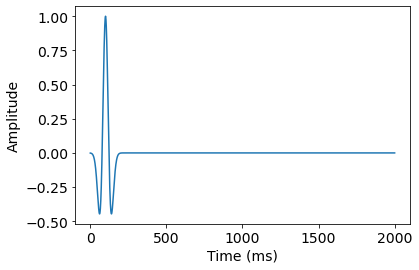

In [5]:
# Source in the center of the model at 10 Hz center frequency
fpeak = 0.010
src = RickerSource(name='src', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src.coordinates.data[0,0] = dx * (nx//2)
src.coordinates.data[0,1] = dz * (nz//2)

# line of receivers along the right edge of the model
rec = Receiver(name='rec', grid=grid, npoint=nz, time_range=time_range)
rec.coordinates.data[:,0] = dx * (nx//2)
rec.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

print("src_coordinate  X;         %+12.4f" % (src.coordinates.data[0,0]))
print("src_coordinate  Z;         %+12.4f" % (src.coordinates.data[0,1]))
print("src_coordinates X min/max; %+12.4f %+12.4f" % \
      (np.min(rec.coordinates.data[:,0]), np.max(rec.coordinates.data[:,0])))
print("src_coordinates Z min/max; %+12.4f %+12.4f" % \
      (np.min(rec.coordinates.data[:,1]), np.max(rec.coordinates.data[:,1])))

# We can plot the time signature to see the wavelet
src.show()

## Plot velocity model

Next we plot the half-space velocity model for illustration. 
- The demarcation between interior and absorbing boundary is shown with a dotted white line
- The source is shown as a large red asterisk
- The extent of the receiver array is shown with a thick dashed blue line

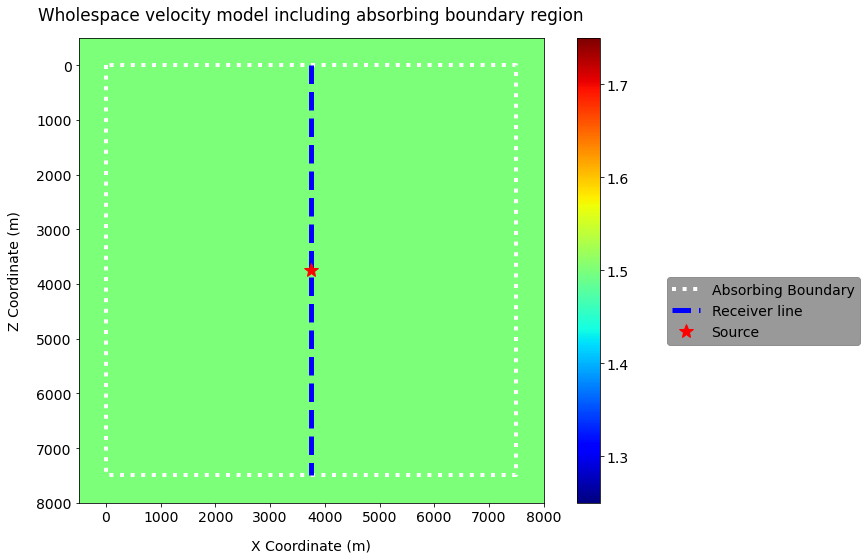

In [6]:
# note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + spacing[0]*(shape_pad[0]-1), 
              origin_pad[1] + spacing[1]*(shape_pad[1]-1), origin_pad[1]]

plt.figure(1, figsize=(12,8))
plt.clf()
plt.imshow(np.transpose(v.data), cmap=cm.jet, vmin=1.25, vmax=1.75, extent=plt_extent)
plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]], 
         [origin[1], extent[1], extent[1], origin[1], origin[1]], 
         'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1], \
         'blue', linewidth=5, linestyle='--', label="Receiver line")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
ax = plt.legend(bbox_to_anchor=(1.25, 0.5), loc='upper left')
ax.get_frame().set_color("gray")
plt.colorbar()
plt.xlabel("X Coordinate (m)", labelpad=15)
plt.ylabel("Z Coordinate (m)", labelpad=15)
plt.title("Wholespace velocity model including absorbing boundary region", y=1.025)
plt.tight_layout()
None

## Define The $\omega_c\ /\ Q(x,z)$ model used for dissipation only attenuation

In the previous notebook we defined a python function used to initialize the  $\omega_c\ /\ Q(x,z)$ profile and then used that function to populate our attenuation profile. Please see the figure in that notebook, not repeated here.

In [7]:
# Initialize the attenuation profile
w = 2.0 * np.pi * fpeak
print("w,fpeak; ", w, fpeak)
qmin = 0.1
qmax = 100.0
wOverQ = Function(name='wOverQ', grid=grid, space_order=space_order)
setup_wOverQ(wOverQ, w, qmin, qmax, npad)

Allocating memory for wOverQ(867, 867)
Allocating memory for f_c(947, 947)


w,fpeak;  0.06283185307179587 0.01


Operator `smooth` generated in 0.53 s
  * lowering.Clusters: 0.22 s (41.7 %)
     * specializing.Clusters: 0.14 s (26.5 %)
  * lowering.Expressions: 0.17 s (32.2 %)
  * lowering.IET: 0.11 s (20.9 %)
Flops reduction after symbolic optimization: [130 --> 98]
Allocating memory for f_o(885, 885)
Operator `smooth` fetched `/tmp/devito-jitcache-uid5138/740485db37ef92aad2a2e993522472be117304fa.c` in 0.14 s from jit-cache
Operator `smooth` run in 0.01 s
* section0<<16,883>,<16,883>,<851,851>,<851,851>,<883,16>,<883,16>,<851,851>,<851,851>> with OI=0.01 computed in 0.01 s [15.19 GFlops/s]
Performance[mode=advanced] arguments: {'nthreads': 16}


setup_wOverQ ran in 0.9751 seconds -- min/max Q values; 0.1000 100.0000


## Define the pressure wavefield as a ```TimeFunction```

We specify the time_order as 2, which allocates 3 time steps in the pressure wavefield. As described elsewhere, Devito will use "cyclic indexing" to index into this multi-dimensional array.

In [8]:
# Define the TimeFunction
p = TimeFunction(name="p", grid=grid, time_order=2, space_order=space_order)

# Get the dimensions and spacing for t, x, z 
t,x,z = p.dimensions
h_t = t.spacing
h_x = x.spacing
h_z = z.spacing

## Define the source injection and receiver extraction 

In [9]:
# Finally we define the source injection and receiver extraction functions 
src_term = src.inject(field=p.forward, expr=src * h_t**2 * v**2 / b)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=p.forward)

## Finally, the Devito operator

We next transcribe the time update expression above into a Devito ```Eq```. Then we add the source injection and receiver extraction and build an ```Operator``` that will generate the c++ code for performing the model.

We copy the time update expression from above for clarity. Note we omit $s$ from the ```Eq``` below because we will be explicitly injecting the source using ```src_term```.

$$
\begin{aligned}
    P(t+\delta t) &=
        \frac{\delta t^2 v^2}{b} \left[ 
            \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x} P \right) +
            \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y} P \right) +
            \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z} P \right) + s
        \right] \\[5pt]
        &\quad +\ P(t) \left(2 - \frac{\delta t^2 \omega_c}{Q} \right)
        - P(t-\delta t) \left(1 - \frac{\delta t\ \omega_c}{Q} \right)
\end{aligned}
$$

In [10]:
#NBVAL_IGNORE_OUTPUT
eq_time_update = (h_t**2 * v**2 / b) * \
    ((b * p.dx(x0=x+h_x/2)).dx(x0=x-h_x/2) + \
     (b * p.dz(x0=z+h_z/2)).dz(x0=z-h_z/2)) + \
    p * (2 - h_t**2 * wOverQ) - p.backward * (1 - h_t * wOverQ)

stencil = Eq(p.forward, eq_time_update)

op = Operator([stencil] + src_term + rec_term, subs=p.grid.spacing_map)

Operator `Kernel` generated in 1.60 s
  * lowering.Expressions: 0.89 s (55.9 %)
  * lowering.Clusters: 0.41 s (25.8 %)
Flops reduction after symbolic optimization: [300 --> 69]


In [11]:
# run the operator
print("v        min/max; %+12.6e %+12.6e" % (np.min(v.data), np.max(v.data)))
print("b        min/max; %+12.6e %+12.6e" % (np.min(b.data), np.max(b.data)))
print("wOverQ   min/max; %+12.6e %+12.6e" % (np.min(wOverQ.data), np.max(wOverQ.data)))
print(time_range)
# summary = op(time=time_range.num-1, h_x=dx, h_z=dz, dt=dt)
# print("data min/max; %+12.6e %+12.6e" % (np.min(p.data[1,:,:]), np.max(p.data[1,:,:])))

v        min/max; +1.500000e+00 +1.500000e+00
b        min/max; +1.000000e-03 +1.000000e-03
wOverQ   min/max; +6.283185e-04 +6.283185e-01
TimeAxis: start=0, stop=2000, step=1, num=2001


## Plot the computed wavefield

In [12]:
# Plot the wavefield in the model
# plt.figure(1, figsize=(12,8))
# plt.clf()
# amax = np.max(np.abs(p.data[1,:,:]))
# plt.imshow(np.transpose(p.data[1,:,:]), vmin=-amax, vmax=+amax, cmap="seismic", extent=plt_extent)
# plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]], 
#          [origin[1], extent[1], extent[1], origin[1], origin[1]], 
#          'black', linewidth=4, linestyle=':', label="Absorbing Boundary")
# plt.plot(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1], \
#          'blue', linewidth=5, linestyle='--', label="Receiver line")
# plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
#          'red', linestyle='None', marker='*', markersize=15, label="Source")
# ax = plt.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left')
# ax.get_frame().set_color("gray")
# plt.xlabel('X coordinate (m)')
# plt.ylabel('Z coordinate (m)')
# plt.title('Model wavefield at time = %.2f msec' % (time_range.stop))
# plt.tight_layout()

# # Plot the receiver wavefield
# plt.figure(figsize=(8,8))
# amax = np.max(np.abs(rec.data[:])) / 10
# plt.imshow(rec.data[:,:], vmin=-amax, vmax=+amax, cmap="seismic", aspect="auto")
# plt.xlabel('Z coordinate (m)')
# plt.ylabel('Time (msec)')
# plt.title('Receiver wavefield')
# plt.tight_layout()

<a id="nl_refs"></a>
## References
<br>

- **A nonreflecting boundary condition for discrete acoustic and elastic wave equations** (1985)
<br>Charles Cerjan, Dan Kosloff, Ronnie Kosloff, and Moshe Resheq
<br> Geophysics, Vol. 50, No. 4
<br>https://library.seg.org/doi/pdfplus/10.1190/segam2016-13878451.1
<br>

- **Generation of Finite Difference Formulas on Arbitrarily Spaced Grids** (1988)
<br>Bengt Fornberg
<br>Mathematics of Computation, Vol. 51, No. 184
<br>http://dx.doi.org/10.1090/S0025-5718-1988-0935077-0
<br>https://web.njit.edu/~jiang/math712/fornberg.pdf
<br>

- **Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1
